# Parallelized Deep Convolutional Neural Networks for Pathology Detection and Localization in Chest X-Rays

* Name   : **Rammuni Ravidu Suien Silva**
* Module : **Final Year Project 20/21**
* UoW No : **16267097**
* IIT No : **2016134**
* Supervisor: Mr. Pumudu Fernando

*University of Westminster | IIT Sri Lanka*
* Prototype
* Model: PAR-128-MODEL-MIMIC

### System Specifications

In [1]:
!pip install system_query

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import system_query 
system_query.query_all()

{'host': '4379e21f9e81',
 'os': 'Linux-5.4.89+-x86_64-with-debian-buster-sid',
 'cpu': {},
 'gpus': [{'brand': 'Tesla P100-PCIE-16GB',
   'memory': 17071734784,
   'memory_clock': 715000,
   'compute_capability': 6.0,
   'clock': 1328500,
   'multiprocessors': 56,
   'cores': 3584,
   'warp_size': 32}],
 'ram': {'total': 16795631616},
 'hdds': {},
 'swap': 0}

### GPU Information

In [3]:
import pprint
import subprocess as sbp

sp = sbp.Popen(['nvidia-smi'], stdout=sbp.PIPE, stderr=sbp.PIPE)

info_data = str(sp.communicate()[0]).split('\\n')

for data in info_data:
    print(data)

b'Fri Mar 26 05:11:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |    255MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----

# Model for CXR classification
### MIMIC-CXR 2020 Dataset

Imporing Required Libraries
* Tensorflow was used as the main library for this project. The decision was taken considering the performance, support and the feature available
* Apart from that matplotlib, numpy, pands, OpenCV, sklearn are the other libraries used

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing
import os
from glob import glob
from datetime import datetime

In [5]:
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.compat.v1.logging import INFO, set_verbosity
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPool2D, Multiply, Concatenate, Input 
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_auc_score, roc_curve
set_verbosity(INFO)

In [6]:
#Recording Start Time
notebook_start = datetime.now()

#Labels for model training
xray_labels = ["Enlarged Cardiomediastinum",
               "Cardiomegaly",
               "Lung Lesion",
               "Lung Opacity",
               "Edema",
               "Consolidation",
               "Pneumonia",
               "Atelectasis",
               "Pneumothorax",
               "Pleural Effusion",
               "Pleural Other",
               "Fracture",
               "Support Devices"]

# Data pre-processing

In [7]:
#importing the labells
xray_dataset_fnl = pd.read_csv("../input/mimic-negbio-lbls/mimic_negbio_lbls.csv")

In [8]:
#Generating pandas Data frames
is_train = (xray_dataset_fnl["split"] == "train")
is_test = (xray_dataset_fnl["split"] == "test")
is_valid = (xray_dataset_fnl["split"] == "validate")

train_xray_dataset = xray_dataset_fnl[is_train] 
valid_xray_dataset = xray_dataset_fnl[is_valid]
test_xray_dataset = xray_dataset_fnl[is_test]
train_xray_dataset.reset_index(drop=True, inplace=True)
valid_xray_dataset.reset_index(drop=True, inplace=True)
test_xray_dataset.reset_index(drop=True, inplace=True)
print("Train Split dimensions: ",train_xray_dataset.shape)
print("Validation Split dimensions: ",valid_xray_dataset.shape)
print("Test Split dimensions: ",test_xray_dataset.shape)

Train Split dimensions:  (368945, 19)
Validation Split dimensions:  (2991, 19)
Test Split dimensions:  (5159, 19)


In [9]:
#Completing the labels
train_xray_dataset[xray_labels] = ((train_xray_dataset[xray_labels].to_numpy() == 1.0)*1.0)
valid_xray_dataset[xray_labels] = ((valid_xray_dataset[xray_labels].to_numpy() == 1.0)*1.0)
test_xray_dataset[xray_labels] = ((test_xray_dataset[xray_labels].to_numpy() == 1.0)*1.0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

### Head of Test, Validation and Training labels

In [10]:
train_xray_dataset.head()

,Path,dicom_id,study_id,subject_id_x,split,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,p10/p10000032/s50414267/02aa804e-bde0afdd-112c...,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,50414267,10000032,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,p10/p10000032/s50414267/174413ec-4ec4c1f7-34ea...,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,50414267,10000032,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,p10/p10000032/s53189527/2a2277a9-b0ded155-c0de...,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,53189527,10000032,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,p10/p10000032/s53189527/e084de3b-be89b11e-20fe...,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,53189527,10000032,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,p10/p10000032/s53911762/68b5c4b1-227d0485-9cc3...,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,53911762,10000032,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [11]:
valid_xray_dataset.head()

,Path,dicom_id,study_id,subject_id_x,split,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,p10/p10003502/s50084553/70d7e600-373c1311-929f...,70d7e600-373c1311-929f5ff9-23ee3621-ff551ff9,50084553,10003502,validate,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0
1,p10/p10003502/s51180958/1fa79752-9ddaf5b5-2120...,1fa79752-9ddaf5b5-2120ae82-9fec50d6-51f48d1f,51180958,10003502,validate,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
2,p10/p10003502/s51180958/a8319f39-9eef5bb2-5bd9...,a8319f39-9eef5bb2-5bd95b97-9dd70b0f-02a846e3,51180958,10003502,validate,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
3,p10/p10003502/s52139270/489faba7-a9dc5f1d-fd72...,489faba7-a9dc5f1d-fd7241d6-9638d855-eaa952b1,52139270,10003502,validate,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0
4,p10/p10003502/s52139270/550e6f3b-f008c1d0-8d2d...,550e6f3b-f008c1d0-8d2dee2a-649b30f4-101a98cc,52139270,10003502,validate,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0


In [12]:
test_xray_dataset.head()

,Path,dicom_id,study_id,subject_id_x,split,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,p10/p10032725/s50331901/687754ce-7420bfd3-0a19...,687754ce-7420bfd3-0a19911f-a27a3916-9019cd53,50331901,10032725,test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,p10/p10032725/s55504914/fd4126e5-c5485b35-3bbc...,fd4126e5-c5485b35-3bbc48fc-acb448fa-fb1b42b7,55504914,10032725,test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,p10/p10046166/s50051329/427446c1-881f5cce-8519...,427446c1-881f5cce-85191ce1-91a58ba9-0a57d3f5,50051329,10046166,test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,p10/p10046166/s50051329/abea5eb9-b7c32823-3a14...,abea5eb9-b7c32823-3a14c5ca-77868030-69c83139,50051329,10046166,test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,p10/p10046166/s51738740/3a8a17fc-3cd357d9-8346...,3a8a17fc-3cd357d9-83466363-91dc5a06-a401e5ed,51738740,10046166,test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### **Pre-processing techniques used**
* Samplewise normalization and center was applied for the CXR images to improve training. 
* Image size was reduced to 320x320 px considering the harware limitations
* Data Augmentation was done using random horizontal flips of CXR Images
* Generators was used to improve the training performances and the ease of development

In [13]:
#Generator for training split
def get_train_generator(input_df, image_directory, x_col, y_cols, shuffle=True, 
                        batch_size=16, img_width = 320, img_height = 320):

    print("Creating TrainGenerator...") 
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        horizontal_flip=True)
    
    generator = image_generator.flow_from_dataframe(
            dataframe=input_df,
            directory=image_directory,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            target_size=(img_width,img_height))
    
    return generator

In [14]:
#Generator for validation split
def get_valid_generator(input_df, image_directory, x_col, y_cols, shuffle=True, 
                        sample_size=100, batch_size=16, img_width = 320, img_height = 320):

    print("Creating ValidGenerator...")

    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)

    valid_generator = image_generator.flow_from_dataframe(
            dataframe=input_df,
            directory=image_directory,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            target_size=(img_width,img_height))

    return valid_generator

In [15]:
#Generator for test split
def get_test_generator(input_df, image_directory, x_col, y_cols, sample_size=100,
                       batch_size=16, img_width = 320, img_height = 320):
    
    print("Creating TestGenerator")

    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)

    test_generator = image_generator.flow_from_dataframe(
            dataframe=input_df,
            directory=image_directory,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            target_size=(img_width,img_height))

    return test_generator

In [16]:
#Dataset directory
DATASET_DIR = "../input/fyp0001/MIMIC_DATA/files"

In [17]:
start = datetime.now()
train_generator = get_train_generator(train_xray_dataset, DATASET_DIR, "Path", xray_labels)
print("TrainGenerator creation time: ",datetime.now() - start)

Creating TrainGenerator...
Found 368945 validated image filenames.
TrainGenerator creation time:  0:30:48.697202


In [18]:
start = datetime.now()
valid_generator = get_valid_generator(valid_xray_dataset, DATASET_DIR, "Path", xray_labels)
print("ValidGenerator creation time: ",datetime.now() - start)

Creating ValidGenerator...
Found 2991 validated image filenames.
ValidGenerator creation time:  0:00:15.225322


In [19]:
start = datetime.now()
test_generator = get_test_generator(valid_xray_dataset, DATASET_DIR, "Path", xray_labels)
print("TestGenerator creation time: ",datetime.now() - start)

Creating TestGenerator
Found 2991 validated image filenames.
TestGenerator creation time:  0:00:00.797677


### Sample pre-processed CXRs

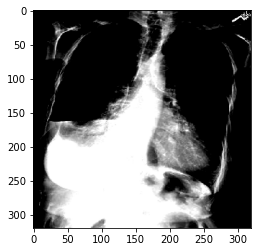

In [20]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])

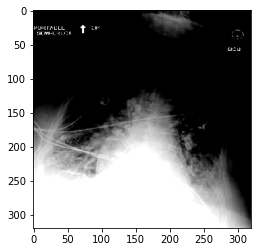

In [21]:
x, y = valid_generator.__getitem__(0)
plt.imshow(x[0])

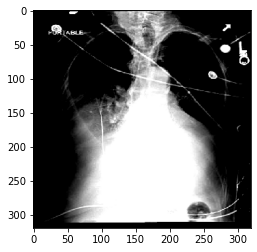

In [22]:
x, y = test_generator.__getitem__(0)
plt.imshow(x[0])

# Dealing with data imbalance issue
This will allow the training to be done equaly on positive and negative labels

In [23]:
#Calculating label frequecies per class
def cal_class_freqencies(train_labels):
  sample_count = train_labels.shape[0]
  positive_freq = np.sum(train_labels == 1.0, axis=0)/sample_count
  negative_freq = 1 - positive_freq 
  return positive_freq, negative_freq

In [24]:
positive_freq, negative_freq = cal_class_freqencies(train_xray_dataset[xray_labels].to_numpy())

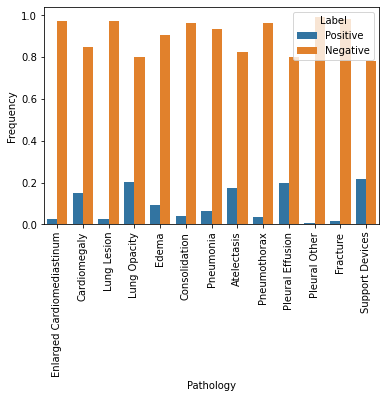

In [25]:
data = pd.DataFrame({"Pathology": xray_labels, "Label": "Positive", "Frequency": positive_freq})
data = data.append([{"Pathology": xray_labels[l], "Label": "Negative", "Frequency": v} for l,v in enumerate(negative_freq)], 
                   ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Pathology", y="Frequency", hue="Label" ,data=data)

In [26]:
#Weight Calculation
pos_freq_weights = negative_freq
neg_freq_weights = positive_freq
pos_lbl_contribution = positive_freq * pos_freq_weights 
neg_lbl_contribution = negative_freq * neg_freq_weights

### Visual verification of weighted classes

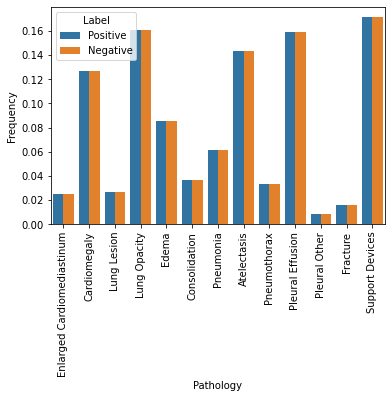

In [27]:
data = pd.DataFrame({"Pathology": xray_labels, "Label": "Positive", "Frequency": pos_lbl_contribution})
data = data.append([{"Pathology": xray_labels[l], "Label": "Negative", "Frequency": v} for l,v in enumerate(neg_lbl_contribution)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Pathology", y="Frequency", hue="Label" ,data=data)

# Model Training

### Wieghted binary cross entropy loss

In [28]:
#Wieghted binary cross entropy loss
def get_weighted_loss(pos_freq_weights, neg_freq_weights, epsilon_add=1e-7):
    def weighted_loss(y_truth, y_detect):
        loss = 0.0
        for i in range(len(pos_freq_weights)):
            loss +=  -(
                K.mean(
                    neg_freq_weights[i] * ((1-y_truth[:,i]) * K.log(1 - y_detect[:,i] + epsilon_add)), axis=0
                ) +
                K.mean( 
                    pos_freq_weights[i] * (y_truth[:,i] * K.log(y_detect[:,i] + epsilon_add)), axis=0
                )
            )
        return loss
    return weighted_loss

In [29]:
#Optimizer definition
adam_opt = Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adam',
)

### Parallelized Model Architecture
ResNet50V2, DenseNet121 and DenseNet169 are parallelized

In [30]:
#Model Imports

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import DenseNet169

In [31]:
combinedInput = Input(batch_shape=(None, None, None, 3))

In [32]:
# Base models preoaded with imagenet weights
resnetV2_m = ResNet50V2(weights='imagenet', include_top=False, 
                              input_shape=(320,320,3), input_tensor=combinedInput)
densenet121_m = DenseNet121(weights='imagenet', include_top=False, 
                               input_shape=(320,320,3), input_tensor=combinedInput)
densenet169_m = DenseNet169(weights='imagenet', include_top=False, 
                               input_shape=(320,320,3), input_tensor=combinedInput)

51879936/51877672 [==============================] - 0s 0us/step


In [33]:
for layer in resnetV2_m.layers:
    layer._name = layer.name + str("_0")
    
for layer in densenet121_m.layers:
    layer._name = layer.name + str("_1")
    
for layer in densenet169_m.layers:
    layer._name = layer.name + str("_2")

In [34]:
base_model_output = []
base_model_output.append(resnetV2_m.output)
base_model_output.append(densenet121_m.output)
base_model_output.append(densenet169_m.output)

### Parallelize Custom Block

In [35]:
def parallelize_block(tensor, ratio=128):
    nb_channel = K.int_shape(tensor)[-1]
    
    # Averaging
    x = GlobalAveragePooling2D()(tensor)
    x = Dense(nb_channel // ratio, activation='relu')(x)
    x = Dense(nb_channel, activation='sigmoid')(x)

    # Weighting
    x = Multiply()([tensor, x])
    return x

### Model Compilation

In [36]:
c_model = Concatenate()(base_model_output)

par_c_model = parallelize_block(c_model)

x = GlobalAveragePooling2D()(par_c_model)

detection_output = Dense(len(xray_labels), activation="sigmoid")(x)

model = Model(inputs=combinedInput, outputs=detection_output) 
model.compile( optimizer=adam_opt, loss=get_weighted_loss(pos_freq_weights, neg_freq_weights))

### Model Summary

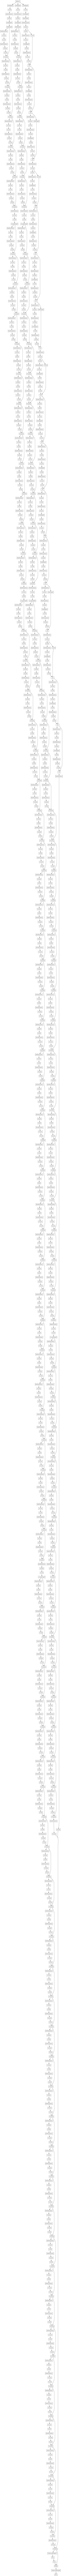

In [37]:
from tensorflow.keras.utils import plot_model 
plot_model( model, to_file='model.png', show_shapes=False, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=96 )

In [38]:
#model.summary()

### Callback definitions

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [40]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=0, verbose=1, mode='min',
    min_delta=0.001, cooldown=1, min_lr=0.000001
)

In [41]:
checkpoint_path = "cp-{epoch:04d}.ckpt"
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=4500)

In [42]:
#Setting Learning Rate to 10e-4
K.set_value(model.optimizer.learning_rate, 0.0001)

# Model Fitting

Epoch 1/10
4499/4500 [============================>.] - ETA: 0s - loss: 1.1171
Epoch 00001: saving model to cp-0001.ckpt
4500/4500 [==============================] - 2710s 602ms/step - loss: 1.1171 - val_loss: 1.1040 - lr: 1.0000e-04
Epoch 2/10
4499/4500 [============================>.] - ETA: 0s - loss: 1.0723
Epoch 00002: saving model to cp-0002.ckpt
4500/4500 [==============================] - 2700s 600ms/step - loss: 1.0723 - val_loss: 1.0747 - lr: 1.0000e-04
Epoch 3/10
4499/4500 [============================>.] - ETA: 0s - loss: 1.0440
Epoch 00003: saving model to cp-0003.ckpt
4500/4500 [==============================] - 2693s 599ms/step - loss: 1.0439 - val_loss: 1.0610 - lr: 1.0000e-04
Epoch 4/10
4499/4500 [============================>.] - ETA: 0s - loss: 1.0286
Epoch 00004: saving model to cp-0004.ckpt
4500/4500 [==============================] - 2697s 599ms/step - loss: 1.0285 - val_loss: 1.0472 - lr: 1.0000e-04
Epoch 5/10
4499/4500 [============================>.] - ETA: 0s 

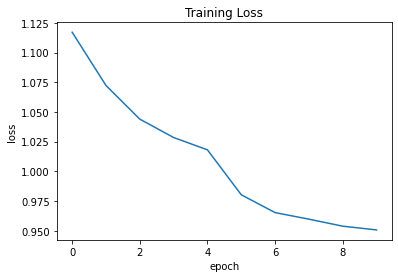

Total Model Fitting Time:  7:35:16.707779


In [43]:
start = datetime.now()
history = model.fit(
    x=train_generator, validation_data=valid_generator, steps_per_epoch=4500, validation_steps=187, epochs=10, 
    verbose=1,  workers=4, use_multiprocessing=True, callbacks=[cp_callback, reduce_lr]
)
plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss")
plt.show()
print("Total Model Fitting Time: ",datetime.now() - start)

# Model Evaluation Results

### ROC-AUC Curve generation

In [44]:
def get_roc_curve(labels, detection_results_vals, generator):
    auc_roc_vals_lst = []
    for i in range(len(labels)):
        try:
            g_label = generator.labels[:, i]
            output_vals = detection_results_vals[:, i]
            auc_roc_val = roc_auc_score(g_label, output_vals)
            auc_roc_vals_lst.append(auc_roc_val)
            fpr_rf, tpr_rf, _ = roc_curve(g_label, output_vals)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc_val, 4)) + ")")
            plt.xlabel('FPR - False Positive Rate')
            plt.ylabel('TPR - True Positive Rate')
            plt.title('AUC - ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating AUC-ROC curve for {labels[i]}. "
            )
    plt.show()
    return auc_roc_vals_lst

### True Positive Rate Vs. False Positive Rate Curves
Below are the AUC curves for each pathology classified

187/187 [==============================] - 33s 174ms/step


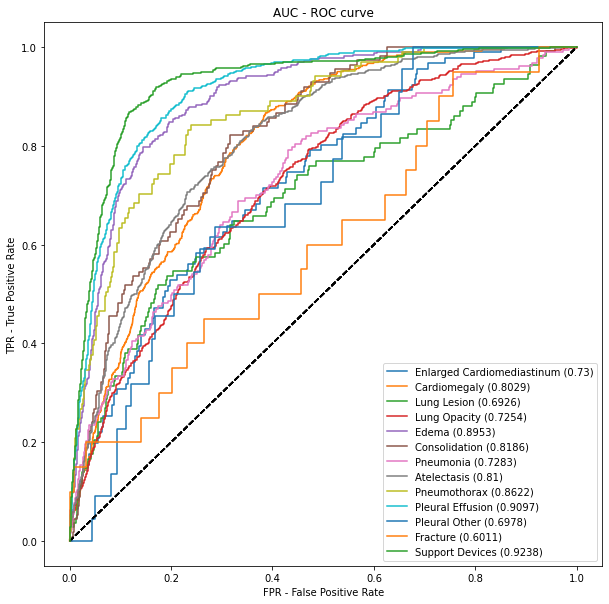

In [45]:
model.load_weights("cp-0005.ckpt")

detection_results_vals = model.predict(test_generator, verbose=1, steps = len(test_generator))
auc_roc_graph = get_roc_curve(xray_labels, detection_results_vals, test_generator)

187/187 [==============================] - 32s 173ms/step


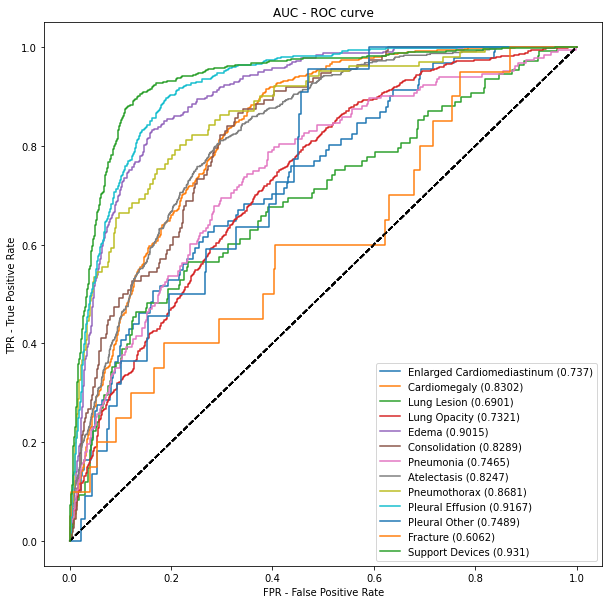

In [46]:
model.load_weights("cp-0006.ckpt")

detection_results_vals = model.predict(test_generator, verbose=1, steps = len(test_generator))
auc_roc_graph = get_roc_curve(xray_labels, detection_results_vals, test_generator)

In [47]:
model.load_weights("cp-0007.ckpt")
model.save("PAR-128-MODEL-MIMIC-00.h5")

187/187 [==============================] - 32s 174ms/step


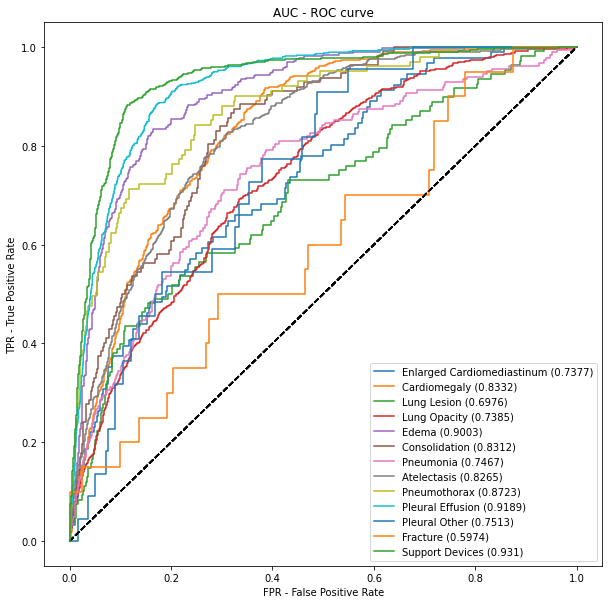

In [48]:
detection_results_vals = model.predict(test_generator, verbose=1, steps = len(test_generator))
auc_roc_graph = get_roc_curve(xray_labels, detection_results_vals, test_generator)

In [49]:
model.load_weights("cp-0008.ckpt")
model.save("PAR-128-MODEL-MIMIC-0.h5")

187/187 [==============================] - 32s 172ms/step


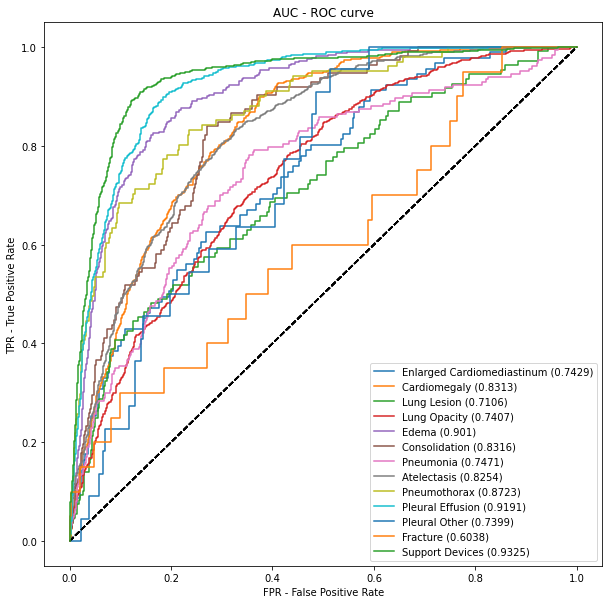

In [50]:
detection_results_vals = model.predict(test_generator, verbose=1, steps = len(test_generator))
auc_roc_graph = get_roc_curve(xray_labels, detection_results_vals, test_generator)

In [51]:
model.load_weights("cp-0009.ckpt")
model.save("PAR-128-MODEL-MIMIC-1.h5")

187/187 [==============================] - 32s 173ms/step


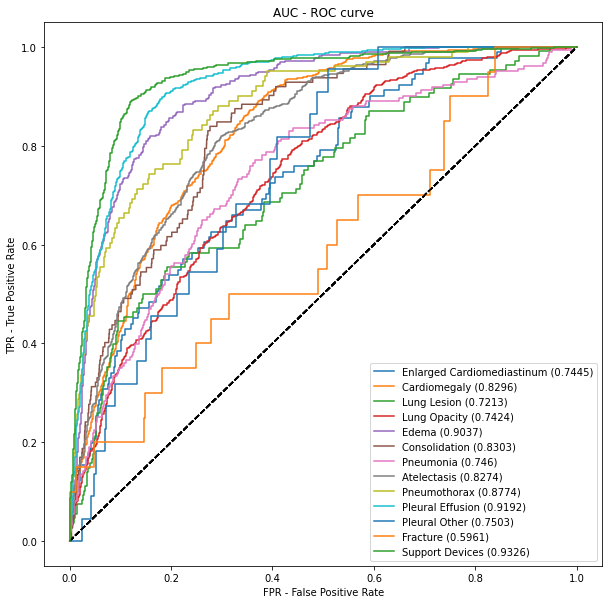

In [52]:
detection_results_vals = model.predict(test_generator, verbose=1, steps = len(test_generator))
auc_roc_graph = get_roc_curve(xray_labels, detection_results_vals, test_generator)

In [53]:
model.load_weights("cp-0010.ckpt")
model.save("PAR-128-MODEL-MIMIC-2.h5")

187/187 [==============================] - 32s 172ms/step


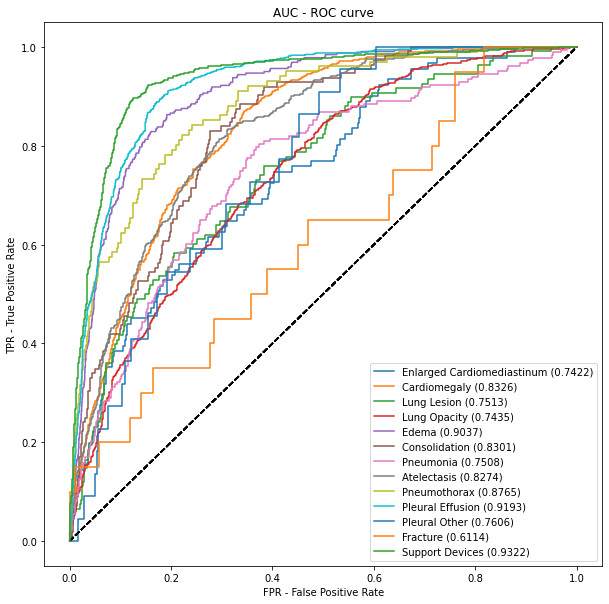

In [54]:
detection_results_vals = model.predict(test_generator, verbose=1, steps = len(test_generator))
auc_roc_graph = get_roc_curve(xray_labels, detection_results_vals, test_generator)

In [55]:
#Total Notebook runtime
print("Total Notebook runtime: ",datetime.now() - notebook_start)

Total Notebook runtime:  8:23:42.482693
